# Machine learning da base

Nesse arquivo a gente vai completar com modelos de regressão lineares o projeto da base que estamos trabalhando no arquivo 01 e 02

## Importações da bases e dependências

In [1]:
import pandas as pd
import seaborn as sns

import plotly.express as px

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import  ElasticNet, LinearRegression
from sklearn.preprocessing import (
    OrdinalEncoder, OneHotEncoder, PolynomialFeatures, PowerTransformer,
    RobustScaler, StandardScaler, QuantileTransformer
)
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import plot_coeficientes, plot_comparar_metricas_modelos, plot_residuos_estimador
from src.models import treinar_e_validar_modelo_regressao, organiza_resultados, grid_search_cv_regressor


In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedroomns_per_room        17564 non-null  floa

## Ajustando a natureza das categorias

A primeira coisa, após o tratamento, é entender a natureza das categorias, se elas são categóricas ou não, qual é o target e, assim, definir o melhor preprocessing para nossas features.

Na nossa base, o objetivo é prever o preço médio das casas; portanto, o target é *median_house_value*.

In [3]:
coluna_target = ['median_house_value']

### Colunas categóricas

Conforme discutido no arquivo de análise e tratamento, este nosso dataframe possui duas colunas categóricas: `ocean_proximity` e `median_income_cat`.

A coluna de renda mediana foi dividida por nós em categorias com o intuito de criar maior correlação com nosso target, enquanto a proximidade com o oceano já nasceu categórica por si mesma. Entretanto, elas apresentam duas formas distintas de categorias: enquanto a renda mediana é ordenada, a proximidade com o oceano não é, o que faz com que tenhamos que usar tratamentos diferentes.


In [4]:
coluna_one_hot_encoder = ['ocean_proximity']

coluna_ordinal_enconder = ['median_income_cat']

O preprocessor **OneHotEncoder** é capaz de transformar variáveis categóricas nominais em representações binárias (0 e 1), criando uma coluna para cada categoria possível. Por isso, escolhemos utilizá-lo nessa coluna categórica, pois não há relação de ordem entre as categorias e precisamos evitar que o modelo interprete valores como hierárquicos.

O preprocessor **OrdinalEncoder** é capaz de converter categorias em valores numéricos inteiros preservando uma relação de ordem predefinida entre elas. Por isso, escolhemos utilizá-lo nessa coluna categórica, pois as categorias possuem hierarquia explícita e essa informação ordinal deve ser mantida para o modelo.


### Processamento

In [5]:
preprocessamento = ColumnTransformer(transformers=[
    ("one_hot_encoder", OneHotEncoder(drop='first'), coluna_one_hot_encoder),
    ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_enconder)
], remainder="passthrough")

Nesse trecho foi definido um `ColumnTransformer` para aplicar diferentes técnicas de pré-processamento a grupos específicos de colunas.

Para as colunas armazenadas em `coluna_one_hot_encoder`, foi aplicado o `OneHotEncoder(drop='first')`. O parâmetro `drop='first'` remove a primeira categoria de cada variável, reduzindo a multicolinearidade, especialmente em modelos lineares.

Para as colunas definidas em `coluna_ordinal_enconder`, foi utilizado o `OrdinalEncoder(categories='auto')`. Com `categories='auto'`, as categorias são identificadas automaticamente a partir dos dados durante o ajuste do modelo. Isso só é possível porque, no tratamento, a coluna foi previamente enumerada com valores inteiros.

O parâmetro `remainder="passthrough"` indica que as demais colunas que não foram especificadas nos transformadores serão mantidas no conjunto de dados sem sofrer alterações.


Após a definição das técnicas de pré-processamento das colunas, o próximo passo é separar a base de dados em X e y, o que é obrigatório para treinar modelos supervisionados.

y representa a variável alvo (target), isto é, o valor que se deseja prever.

X representa o conjunto de variáveis preditoras (features), ou seja, as variáveis explicativas que influenciam o target.

Na variável y, aplicaremos também o PowerTransformer com o intuito de reduzir assimetria da distribuição, aproximar os dados de uma distribuição normal e estabilizar a variância, o que pode melhorar o desempenho e a estabilidade do modelo de regressão.

Em seguida, utilizamos a classe Pipeline da biblioteca scikit-learn para estruturar o fluxo de transformação dos dados e o modelo de regressão de forma organizada e reproduzível.

A Pipeline permite:

- Aplicar etapas de pré-processamento (ex: imputação, normalização, encoding).

- Treinar o modelo de regressão.

Garantir que as mesmas transformações aplicadas no treino sejam replicadas no teste.

In [6]:
X = df.drop(columns=coluna_target)

y = df[coluna_target]

In [7]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedroomns_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [8]:
target_transformer = PowerTransformer()

In [9]:
pipeline = Pipeline([
    ("preprocessor", preprocessamento),
    ("reg", LinearRegression()),
    
])

model = TransformedTargetRegressor(regressor=pipeline, transformer=target_transformer)

Agora é o momento de treinar o modelo. Para isso, utilizaremos duas ferramentas da biblioteca scikit-learn: KFold e cross_validate, que servem para realizar validação cruzada e obter uma estimativa mais robusta do desempenho do modelo.

O KFold é responsável por dividir o conjunto de dados em k subconjuntos (folds), permitindo que o modelo seja treinado múltiplas vezes, cada vez utilizando uma parte diferente dos dados para validação e as demais para treino.

Já o cross_validate executa efetivamente o processo de validação cruzada, treinando o modelo em cada fold e retornando métricas de desempenho (como R², MAE ou RMSE), além de opcionalmente fornecer tempos de treino e teste.

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    model,
    X,
    y,
    cv=kf,
    scoring=[
        "r2",
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
    ],
)

scores

{'fit_time': array([0.06358075, 0.03928328, 0.03204012, 0.03163671, 0.04686451]),
 'score_time': array([0.0030055 , 0.00698066, 0.        , 0.015625  , 0.        ]),
 'test_r2': array([0.68423203, 0.67104229, 0.64609438, 0.67754409, 0.67701394]),
 'test_neg_mean_absolute_error': array([-38127.99008883, -38515.38717619, -40531.12738353, -38827.01294091,
        -38544.77419274]),
 'test_neg_root_mean_squared_error': array([-54078.01826977, -54607.94138065, -57211.35139438, -54501.88032761,
        -54659.33051272])}

In [11]:
resultados = pd.DataFrame(scores)
resultados

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error
0,0.063581,0.003006,0.684232,-38127.990089,-54078.018270
1,0.039283,0.006981,0.671042,-38515.387176,-54607.941381
2,0.032040,0.000000,0.646094,-40531.127384,-57211.351394
3,0.031637,0.015625,0.677544,-38827.012941,-54501.880328
4,0.046865,0.000000,0.677014,-38544.774193,-54659.330513


### Testando vários modelos em função

No arquivo `models.py` eu separei toda a lógica acima em função com intuito de usar vários models e transformer ao mesmo tempo.

In [12]:
regressors = {
    "DumyyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy='mean'),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": target_transformer,
    },
}

In [13]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor) 
    for nome_modelo, regressor in regressors.items()
} 
df_resultados = organiza_resultados(resultados)

df_resultados


,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DumyyRegressor,0.0,0.014294,-0.000081,-77516.042766,-96239.705692,0.014294
1,DumyyRegressor,0.0,0.0,-0.000146,-75787.787194,-95217.629397,0.0
2,DumyyRegressor,0.01462,0.003993,-0.001737,-76753.598961,-96253.253947,0.018613
3,DumyyRegressor,0.002992,0.004987,-0.000101,-76837.804811,-95983.885799,0.007978
4,DumyyRegressor,0.00376,0.003042,-0.000114,-76617.245449,-96182.764729,0.006801
5,LinearRegression,0.011968,0.0,0.682162,-39855.690921,-54254.958115,0.011968
6,LinearRegression,0.019161,0.0,0.66999,-40272.565406,-54695.230224,0.019161
7,LinearRegression,0.018007,0.0,0.649247,-42178.059246,-56955.988686,0.018007
8,LinearRegression,0.030633,0.0,0.669873,-40806.492452,-55146.31876,0.030633
9,LinearRegression,0.01562,0.0,0.669023,-40788.496555,-55331.351171,0.01562


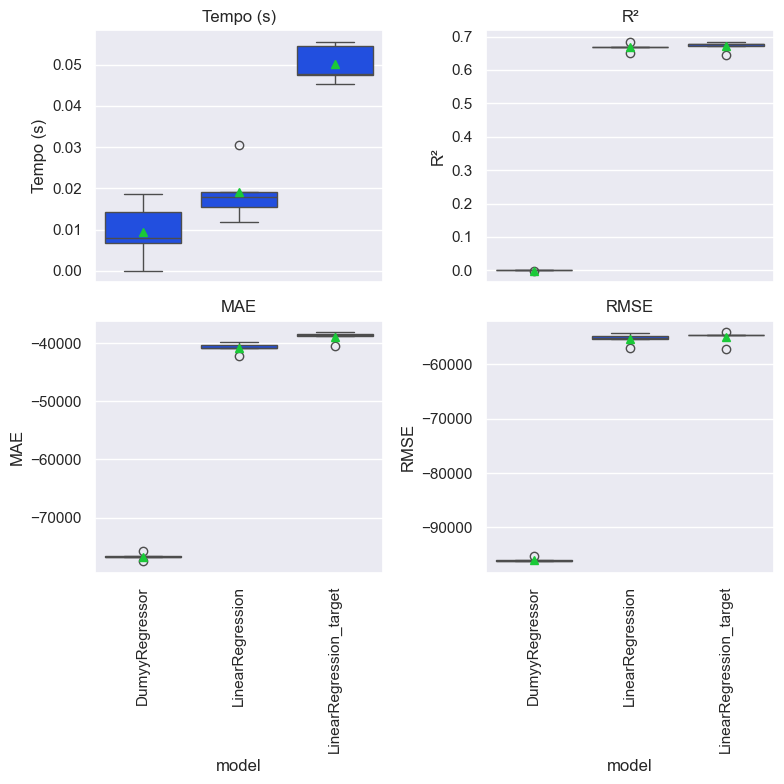

In [14]:
plot_comparar_metricas_modelos(df_resultados)

Podemos observar que o melhor desempenho até o momento foi obtido ao aplicar a transformação no target.

Como próximo passo, podemos avançar utilizando **GridSearchCV**, que já executa validação cruzada internamente, para testar diferentes modelos e estratégias de transformação do target, buscando a combinação de hiperparâmetros que maximize o desempenho do modelo.



No módulo de models, já foi implementada a função responsável por executar o GridSearchCV já usando as minhas funções.

Antes de utilizá-la, é importante esclarecer alguns dos principais parâmetros definidos na chamada, especialmente cv, param_grid, scoring, refit e n_jobs, pois eles determinam como a busca será conduzida, como os modelos serão avaliados e qual métrica será utilizada para selecionar o melhor estimador.

Abaixo está a explicação objetiva dos principais parâmetros utilizados no `GridSearchCV`:


**param_grid**
Dicionário contendo os hiperparâmetros que serão testados e seus respectivos valores.
O Grid Search executa todas as combinações possíveis (busca exaustiva).

**cv=kf**
Estratégia de validação cruzada.
No seu caso, está sendo utilizado um `KFold`, o que significa que para cada combinação de hiperparâmetros o modelo será treinado e validado em múltiplas divisões dos dados.

**scoring**
Lista de métricas que serão calculadas em cada fold.
Você definiu:

* `r2`
* `neg_mean_absolute_error`
* `neg_root_mean_squared_error`

Como há múltiplas métricas, o GridSearch apenas registra todas — mas precisa de uma para decidir qual modelo é o melhor.

**refit="neg_root_mean_squared_error"**
Define qual métrica será usada para selecionar o melhor modelo.
Após identificar a melhor combinação de hiperparâmetros com base nessa métrica, o GridSearch reentreina o modelo final usando todos os dados.


In [15]:
param_grid = {
    "transformer": [None, PowerTransformer(), QuantileTransformer(output_distribution='normal')]
}


**"transformer"**
Refere-se ao parâmetro `transformer` do `TransformedTargetRegressor`.
Ou seja, o Grid Search irá testar diferentes formas de transformação do **target (y)**.

As opções avaliadas serão:

**None**
Nenhuma transformação será aplicada ao target.
O modelo será treinado diretamente com o y original.

**PowerTransformer()**
Aplica transformação paramétrica (ex: Yeo-Johnson) para tornar a distribuição mais próxima da normalidade.
É útil quando o target apresenta assimetria.

**QuantileTransformer(output_distribution="normal")**
Transforma a distribuição do target usando mapeamento por quantis para aproximá-la de uma distribuição normal.
É uma abordagem não paramétrica e pode lidar melhor com distribuições altamente distorcidas.

---

O que o GridSearch fará:

Para cada fold da validação cruzada:

* Testará o modelo sem transformação.
* Testará com `PowerTransformer`.
* Testará com `QuantileTransformer`.
* Comparará os resultados usando a métrica definida em `refit`.

Em seguida, selecionará automaticamente a transformação que gerar o melhor desempenho segundo o critério escolhido.


In [16]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(), 
    preprocessor= preprocessamento, 
    param_grid= param_grid,
    target_transformer=target_transformer
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

Você pode questionar o motivo de existir um `target_transformer`, já que estamos testando múltiplas possibilidades no Grid Search. Nesse contexto, ele serve apenas como um valor inicial padrão para instanciar o `TransformedTargetRegressor`, pois as diferentes transformações efetivamente avaliadas são definidas e sobrescritas pelo `param_grid`.


In [17]:
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [18]:
grid_search.best_params_

{'transformer': QuantileTransformer(output_distribution='normal')}

In [19]:
grid_search.best_score_

-54438.329359294396

In [20]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

coefs

#extraindo os coeficientes do modelo linear vencedor do Grid Search e associando cada coeficiente ao respectivo nome de variável após o pré-processamento.

,coeficiente
one_hot_encoder__ocean_proximity_INLAND,-0.451079
remainder__longitude,-0.291881
remainder__latitude,-0.285407
remainder__population_per_household,-0.277024
one_hot_encoder__ocean_proximity_NEAR BAY,-0.200700
one_hot_encoder__ocean_proximity_NEAR OCEAN,-0.060132
remainder__total_bedrooms,-0.000223
remainder__total_rooms,-0.000060
remainder__population,-0.000034
remainder__households,0.000843


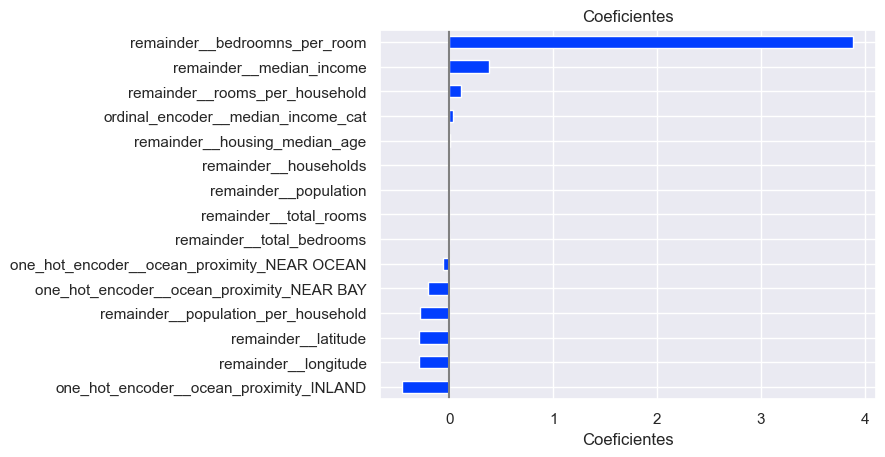

In [21]:
plot_coeficientes(coefs)

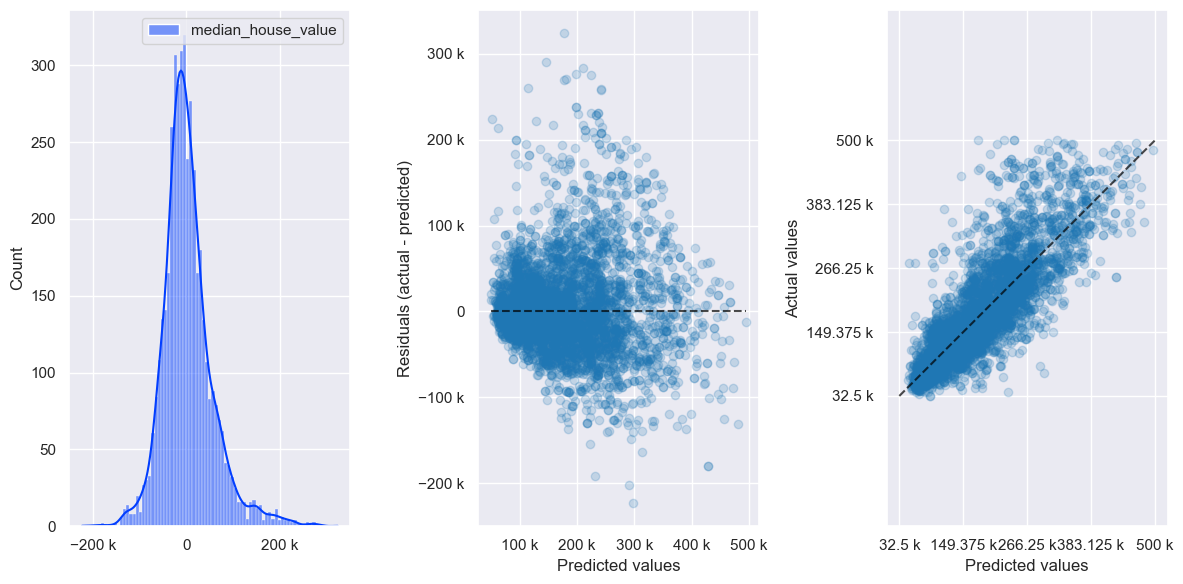

In [22]:
plot_residuos_estimador(grid_search.best_estimator_, X, y,  eng_formatter=True)